# 钙成像数据分析

### 数据平滑
- 信号抖动的太厉害，需要简单的滑动平均算法
    - 滑动平均法：moving average
    - 指数滑动平均法： exponentail mean average
    - SG 滤波法：savitzky golay filter

## 平滑，ΔF/F0

## stimuli_calcium

In [1]:
import pandas as pd
import numpy as np
import os
#from sklearn.manifold import TSNE
from scipy import signal
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
import seaborn as sns




In [2]:
def cal(dir):
    raw=pd.read_csv(dir)
    column_number=len(raw.columns)
    particle_number=int((column_number-1)/ 2)
    inter=dir.split("_")[-1].split(".csv")[0]
    time_list=np.arange(len(raw)) * float(inter)
   
    data=pd.DataFrame({"time":time_list})
    for i in range (0,particle_number):
        value=raw.iloc[:,2*i+2]
        #value=raw.iloc[:,2*i+2].rolling(9,min_periods=1).mean()
        f0=value[20:60].mean()   #   选择数据前多少帧进行F0计算
        value_delta=(value-f0) / f0
        data.insert(i+1,str(i+1),value_delta)
    return data
   



def standardization(data):   #   用于数据的标准化  Z score
    mean=np.mean(data,axis=0)
    std=np.std(data,axis=0)
    return (data-mean) / std


def batch_cal_line(dir_fa):
    for file in os.listdir(dir_fa):
        if ".csv" in file:
            dir=dir_fa+file
            name=file.split(".")[0]
            data=cal(dir)
            print(data)
            data=data.set_index("time")
            sns.set_theme(style="ticks")
            g=sns.lineplot(data,dashes=False)
            vertical_lines = [20,60,100,140,180,220]  # 垂直线的位置
            g.set_ylim(-0.5,1)
            for x in (vertical_lines):
                plt.axvline(x=x, color='r', linestyle='--',alpha=0.2)  # 添加垂直线
            g.set(title=name)
            g.figure.savefig(dir_fa+name+"_line.pdf")
            plt.clf()



def batch_cal_box(dir_fa):
    for file in os.listdir(dir_fa):
        if ".csv" in file:
            dir=dir_fa+file
            name=file.split(".")[0]
            data=cal(dir)
            #print(data)
            real_time_max=data["time"].values[-1]
            data=data.set_index("time")
            g = sns.heatmap(data.T, cmap="RdBu_r", vmin=-0.5, vmax=1)
            if any(x in file for x in ["s4", "S4", "s2", "S2"]):
                v_f03_l = np.array([30, 90, 150, 210, 270] ) # 垂直线的位置
                v_f1_l=v_f03_l+10
                v_f3_l=v_f03_l+20
                v_r1_l=v_f03_l+30
                v_le1_l=v_f03_l+40
                v_ri1_l=v_f03_l+50
            elif any(x in file for x in ["s1", "S1"]):
                v_f03_l = np.array([30, 120, 210])  # 垂直线的位置
                v_f1_l=v_f03_l+15
                v_f3_l=v_f03_l+30
                v_r1_l=v_f03_l+45
                v_le1_l=v_f03_l+60
                v_ri1_l=v_f03_l+75
            elif any(x in file for x in ["s5", "S5"]):
                v_f03_l = np.array([10, 20, 30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,172,174,176])  # 垂直线的位置
                line_s5=np.array([5, 5, 5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1])
                color_s5=["b","b","b","g","y","c","m","m","m","m","m","m","m","m","m","m","g","g","g","g"]
                v_f1_l=v_f3_l=v_r1_l=v_le1_l=v_ri1_l=[0]
            else:
                vertical_lines = [20,60,100,140,180,220] # 垂直线的位置
            x_range = g.get_xlim()  # 获取heatmap的x轴范围
            colo=["r","g","b","y","c","m"]
            n=0
            for y in [v_f03_l,v_f1_l,v_f3_l,v_r1_l,v_le1_l,v_ri1_l]:
                n=n+1
                for x in y:
                    x_heatmap = (x - x_range[0]) / real_time_max # 转换为相对于x轴范围的比例
                    x_plot = int(x_heatmap * x_range[1])  # 将比例乘以绘图区域的宽度
                    #print(x_plot)
                    plt.axvline(x=x_plot,ymax=0.2, color=color_s5[n-1], linestyle='--',alpha=0.2,linewidth=line_s5[n-1])  # 添加垂直线
            g.set(title=name)
            g.figure.savefig(dir_fa+name+"_bx.pdf")
            plt.clf()

In [18]:


def batch_cal_subline(dir_fa):
    for file in os.listdir(dir_fa):
        if ".csv" in file:
            file_path = os.path.join(dir_fa, file)
            name = file.split(".csv")[0]
            data = cal(file_path)
            data = data.set_index("time")

            sns.set_theme(style="ticks")

            # Calculate the number of lines
            num_lines = len(data.columns) - 1

            # Create subplots in a vertical layout
            fig, axes = plt.subplots(num_lines + 1, 1, figsize=(10, 2.5*(num_lines + 1)), sharex=True)

            if num_lines == 0:  # Only one file, create a single plot
                axes = [axes]  # Convert axes object to a list for compatibility
                num_lines = 1
            
            
            # Iterate over each line and plot it
            for i, col in enumerate(data.columns):
                sns.lineplot(data=data, x='time', y=col, ax=axes[i])
                #axes[i].set_ylim(-0.4, 0.4)
                #axes[i].set_xlim(0, 200)
                axes[i].set_ylabel(col)

            # Remove x-axis label from the last subplot
            axes[-1].set_xlabel('')

            # Adjust the spacing between subplots
            plt.subplots_adjust(hspace=0.1)

            # Add vertical lines
            #vertical_lines = [20, 60, 100, 140, 180, 220]
            
            
            if any(x in file for x in ["s4", "S4", "s2", "S2","r7"]):
                list_line = [30, 40, 50, 60, 70,80]
                color_s5=["r","g","b","y","c","m"]
                vertical_lines=[]
                for i in range(5):
                    vertical_lines += [num + i*60 for num in list_line]
                    color_s5 +=color_s5
                line_s5=[5] * 30
                
                

            elif any(x in file for x in ["s1", "S1"]):
                list_line = [30, 45, 60,75,90,105]
                vertical_lines=[]
                color_s5=["r","g","b","y","c","m"]
                for i in range(3):
                    vertical_lines += [num + i*90 for num in list_line]
                    color_s5 +=color_s5
                line_s5=[5] * 18
                
                

            elif any(x in file for x in ["s5", "S5"]):
                vertical_lines = np.array([10, 20, 30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,172,174,176])  # 垂直线的位置
                line_s5=np.array([5, 5, 5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1])
                color_s5=["b","b","b","g","y","c","m","m","m","m","m","m","m","m","m","m","g","g","g","g"]
           
            else:
                vertical_lines = [20,60,100,140,180,220] # 垂直线的位置
                
            n=0
            for line in vertical_lines:
                n=n+1
                for ax in axes:
                    #ax.axvline(x=line, color=color_s5[n-1], linestyle='-',alpha=0.2,linewidth=line_s5[n-1])
                    ax.axvspan(xmin=line,xmax=line+line_s5[n-1], color=color_s5[n-1],linewidth=0,alpha=0.2)
            
            #plt.tight_layout()
            # Set title and save the figure
            fig.suptitle(name)
            fig.savefig(os.path.join(dir_fa, f"{name}_subline_cor.pdf"))
            plt.clf()




## ele_calcium

In [5]:
import pandas as pd
import numpy as np
import os
#from sklearn.manifold import TSNE
from scipy import signal
import matplotlib.pyplot as plt
#from mpl_toolkits import mplot3d
import seaborn as sns

In [3]:
def cal(dir):
    raw=pd.read_csv(dir)
    column_number=len(raw.columns)
    particle_number=int((column_number-1)/ 2)
    inter=dir.split("_")[-1].split(".csv")[0]
    time_list=np.arange(len(raw)) * float(inter)
   
    data=pd.DataFrame({"time":time_list})
    for i in range (0,particle_number):
        value=raw.iloc[:,2*i+2]
        #value=raw.iloc[:,2*i+2].rolling(9,min_periods=1).mean()
        f0=value[20:60].mean()   #   选择数据前多少帧进行F0计算
        value_delta=(value-f0) / f0
        data.insert(i+1,str(i+1),value_delta)
    return data
   



def standardization(data):   #   用于数据的标准化  Z score
    mean=np.mean(data,axis=0)
    std=np.std(data,axis=0)
    return (data-mean) / std


def batch_ele_subline(dir_fa):
    for file in os.listdir(dir_fa):
        if ".csv" in file:
            file_path = os.path.join(dir_fa, file)
            name = file.split(".csv")[0]
            data = cal(file_path)
            data = data.set_index("time")

            sns.set_theme(style="ticks")

            # Calculate the number of lines
            num_lines = len(data.columns) - 1

            # Create subplots in a vertical layout
            fig, axes = plt.subplots(num_lines + 1, 1, figsize=(10, 2.5*(num_lines + 1)), sharex=True)

            if num_lines == 0:  # Only one file, create a single plot
                axes = [axes]  # Convert axes object to a list for compatibility
                num_lines = 1
            
            
            # Iterate over each line and plot it
            for i, col in enumerate(data.columns):
                sns.lineplot(data=data, x='time', y=col, ax=axes[i])
                #axes[i].set_ylim(-0.4, 0.4)
                #axes[i].set_xlim(0, 200)
                axes[i].set_ylabel(col)

            # Remove x-axis label from the last subplot
            axes[-1].set_xlabel('')

            # Adjust the spacing between subplots
            plt.subplots_adjust(hspace=0.1)

            # Add vertical lines
            #vertical_lines = [20, 60, 100, 140, 180, 220]
            
            
          
            vertical_lines = [20,60,100,140,180] # 垂直线的位置
                
            n=0
            for line in vertical_lines:
                n=n+1
                for ax in axes:
                    ax.axvline(x=line, color="r", linestyle='-',alpha=0.2)
            
            #plt.tight_layout()
            # Set title and save the figure
            fig.suptitle(name)
            fig.savefig(os.path.join(dir_fa, f"{name}_subline_cor.pdf"))
            plt.clf()


In [25]:
batch_ele_subline("\\\\10.10.48.40\\priortoreg_data\\311_data_CTL\\CTL_RV\\calcium\\ele_calcium\\good\\20230616_fish3_abla不确定\\")

#\\10.10.48.40\priortoreg_data\311_data_CTL\CTL_RV\calcium\ele_calcium\20230719

<Figure size 1000x1250 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

### 按照DQS methods 进行数据处理
- 注意所有原始csv 还是存放在good路径下的fish文件夹内
- 需要列出可用数据对应的文件名称和 **序号**，以便分析目标数据

In [1]:
# 对应表，数组形式 ,分别：文件名，pre，pre序号，post,post序号, 有的鱼有多个数组，因为多str 或多input
# 真实ablation 12 fish, 算case = 15
# bath 1 fish

N1=["20230606_fish3_bath","aligned_1_20230606_fish3_str1_2_0.1946",1,"aligned_1_20230606_fish3_str1_6_ctrl_0.1476",1,[1,2,3,4,5],[1,2,3,4,5]]

N2=["20230616_fish1_abla","aligned_1_20230616_14dpf_9dpi_fish1_s1_0.1852",1,"aligned_1_20230616_14dpf_9dpi_fish1_s1_03_0.1482",1,[1,2,4,5],[1,2,3,4]]
#N3=["20230630_fish2_abla_依然有反应","aligned_1_20230630_fish2_s1_0.1973",1,"aligned_1_20230630_fish2_s2_0.1983",1]          #反应post 更大

N4=["20230705_fish1_abla","aligned_1_20230705_fish1_s4_0.1605",1,"aligned_1_20230705_fish1_s1-1_0.1718",1,[1,2,3,4,5],[1,2,3,4,5]]   # good post no signal
N5=["20230705_fish1_abla","aligned_1_20230705_fish1_s2_0.17",1,"aligned_1_20230705_fish1_s2-1_0.1718",1,[1,2,3,4,5],[1,2,3,4,5]]    # bad

N6=["20230719_fish2_abla_依然有反应","aligned_1_20230719_fish2_s1_0.1523",1,"aligned_1_20230719_fish2_s3_0.1874",1,[1,2,3,4,5],[1,2,3,4,5]] 
N7=["20230719_fish3__abla","aligned_1_20230719_fish3_s1_0.1601",1,"aligned_1_20230719_fish3_s3_0.1474",1,[1,2,3,4,5],[1,2,3,5]]
N8=["20230719_fish4_abla","aligned_1_20230719_fish4_s1_0.1554",1,"aligned_1_20230719_fish4_s2_0.1612",1,[2,3,5],[1,3,4,5]]    #bad

N9=["20230719_fish5_abla","aligned_1_20230719_fish5_s1_0.1885",2,"aligned_1_20230719_fish5_s2_0.1698",1,[1,2,3,4,5],[1,2,3,4,5]]
N10=["20230719_fish5_abla","aligned_1_20230719_fish5_s1_0.1885",3,"aligned_1_20230719_fish5_s2_0.1698",2,[1,3,4,5],[1,3,4,5]]

#N=["20230719_fish6__abla_有反应——大且滞后",]
N11=["20230726_fish1_abla","aligned_1_20230726_fish1_s2_0.1264",4,"aligned_1_20230726_fish1_s6_0.1766",1,[2,5],[2,4,5]]

N12=["20230726_fish2_abla","aligned_1_20230726_fish2_s1_0.1605",1,"aligned_1_20230726_fish2_s3_0.1386",1,[2],[3,4]]
N13=["20230726_fish2_abla","aligned_1_20230726_fish2_s2_0.123",1,"aligned_1_20230726_fish2_s4_0.1558",1,[1,2],[1,3]]

N14=["20230726_fish3_abla","aligned_1_20230726_fish3_s5_0.1625",1,"aligned_1_20230726_fish3_s6_0.1464",1,[3],[2,3,4,5]]
N15=["20230726_fish4_abla","aligned_1_20230726_fish4_s1_0.1803",3,"aligned_1_20230726_fish4_s6_0.1803",2,[1,3,4,2],[1,3,4,5]]
N16=["20230726_fish6_abla","aligned_1_20230726_fish6_s6_0.1496",1,"aligned_1_20230726_fish6_s7_0.1841",1,[1,2,3,4,5],[1,2,3,4,5]]


#a=[N2,N4,N6,N7,N9,N10,N11,N12,N13,N14,N15]

In [2]:
# 按照DQS methods 进行数据处理
dir="\\\\10.10.48.40\\priortoreg_data\\311_data_CTL\\CTL_RV\\calcium\\ele_calcium\\good\\"


In [3]:
def dqs_cal(dir,number,array_f0):
    raw=pd.read_csv(dir)
    name = dir.split(".csv")[0].split("aligned_")[1]
    print(name)
    column_number=len(raw.columns)
    particle_number=int((column_number-1)/ 2)
    inter=dir.split("_")[-1].split(".csv")[0]
    time_list=np.arange(len(raw)) * float(inter)
   
    data=pd.DataFrame({"time":time_list})

    value=raw.iloc[:,2*(number-1)+2]
    data.insert(1,"value",value)
    
    f0_cource=  [20,60,100,140,180]  # f0 time cource of pre-stimuli
    f0=np.array([])
    
    fig, axes = plt.subplots(5, 1, figsize=(5, 1*(5)), sharex=False)
    
    for i in [1,2,3,4,5]:
        t=f0_cource[i-1]
        
        
        sns.lineplot(data=data, x='time', y="value", ax=axes[i-1])
        #axes[i].set_ylim(-0.4, 0.4)
        axes[i-1].set_xlim(t-20, t+20)
        
        axes[i-1].set_ylabel(i)

        # Adjust the spacing between subplots
        plt.subplots_adjust(hspace=0.6)
        fig.suptitle(name)
        axes[4].set_xlabel(array_f0)
        
    for i in array_f0:   # 选择没有峰的区域作为F0
        t=f0_cource[i-1]
        t_x=np.array(value[int((t-15)/float(inter)) : int((t-5)/float(inter))])
        f0=np.append(f0,t_x)
    
    f0=f0.mean()   #   选择数据前多少帧进行F0计算  
    value_delta=(value-f0) / f0
    data.insert(2,"dF",value_delta)
    
    return data  
    
    

1_20230719_fish5_s1_0.1885


c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

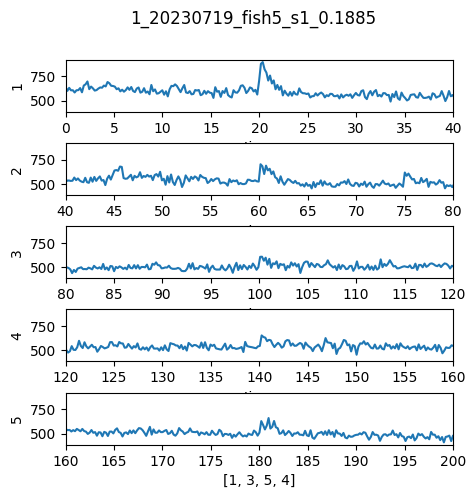

In [6]:

sample=[N10,1]   #pre:1  post:3

csv_dir=dir+sample[0][0]+"\\"+sample[0][sample[1]]+".csv"
data=dqs_cal(csv_dir,sample[0][sample[1]+1],[1,3,5,4])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 按照时间筛选数据
centers = [20, 60, 100, 140, 180]
inter=data["time"][1]

selected_data = pd.DataFrame()
n=0
for center in centers:
    n=n+1
    temp_data = data[int((center - 10)/inter):int((center - 10)/inter)+int(20/inter)]
    temp_data['time_group'] = f"{center}"
    if n==1:
        temp_data['time'] = temp_data['time'] - temp_data['time'].min()
        ccc=temp_data['time']
        #print(ccc)
    else:
        
        temp_data['time']=ccc.values
    selected_data = pd.concat([selected_data, temp_data])


# 绘制图形
sns.lineplot(x="time", y="dF",data=selected_data,errorbar="se")
plt.ylim([-0.1, 0.6])
plt.xlim([9,15])
#sns.lineplot(data=selected_data, x='time', y="dF",hue="time_group")
plt.show()


### amplitude

In [8]:
def dqs_cal_noplot(dir,number,array_f0):
    raw=pd.read_csv(dir)
    name = dir.split(".csv")[0].split("aligned_")[1]
    
    column_number=len(raw.columns)
    particle_number=int((column_number-1)/ 2)
    inter=dir.split("_")[-1].split(".csv")[0]
    time_list=np.arange(len(raw)) * float(inter)
   
    data=pd.DataFrame({"time":time_list})

    value=raw.iloc[:,2*(number-1)+2]
    data.insert(1,"value",value)
    
    f0_cource=  [20,60,100,140,180]  # f0 time cource of pre-stimuli
    f0=np.array([])  
    for i in array_f0:   # 选择没有峰的区域作为F0
        t=f0_cource[i-1]
        t_x=np.array(value[int((t-15)/float(inter)) : int((t-5)/float(inter))])
        f0=np.append(f0,t_x)
    
    f0=f0.mean()   #   选择数据前多少帧进行F0计算  
    value_delta=(value-f0) / f0
    data.insert(2,"dF",value_delta)
    
    return data  

In [8]:
def ave_peak(data,base_array):

    # 按照时间筛选数据
    centers = [20, 60, 100, 140, 180]
    inter=data["time"][1]

    selected_data = pd.DataFrame()
    n=0
    for center in centers:
        n=n+1
        temp_data = data[int((center - 10)/inter):int((center - 10)/inter)+int(20/inter)]
        temp_data['time_group'] = f"{center}"
        if n==1:
            temp_data['time'] = temp_data['time'] - temp_data['time'].min()
            ccc=temp_data['time']
            #print(ccc)
        else:
            
            temp_data['time']=ccc.values
        selected_data = pd.concat([selected_data, temp_data])


    # 获得peak
    time_mean = selected_data.groupby("time")["dF"].mean()
    peak=time_mean[10:10.5].max()
    base=time_mean[base_array[0]:base_array[1]].mean()

    amplitude=peak-base
    # 显示结果
    return amplitude

In [ ]:
#输出 ave peak of single fish case

i=N4

csv_dir=dir+i[0]+"\\"+i[1]+".csv"
data=dqs_cal_noplot(csv_dir,i[2],i[5])

# 按照时间筛选数据
centers = [20, 60, 100, 140, 180]
inter=data["time"][1]

selected_data = pd.DataFrame()
n=0
for center in centers:
    n=n+1
    temp_data = data[int((center - 1)/inter):int((center - 1)/inter)+int(6/inter)]
    temp_data['time_group'] = f"{center}"
    if n==1:
        temp_data['time'] = temp_data['time'] - temp_data['time'].min()
        ccc=temp_data['time']
        #print(ccc)
    else:
        
        temp_data['time']=ccc.values
    selected_data = pd.concat([selected_data, temp_data])


i=N4

csv_dir=dir+i[0]+"\\"+i[3]+".csv"
data=dqs_cal_noplot(csv_dir,i[4],i[6])

# 按照时间筛选数据
centers = [20, 60, 100, 140, 180]
inter=data["time"][1]

selected_data_2 = pd.DataFrame()
n=0
for center in centers:
    n=n+1
    temp_data = data[int((center - 1)/inter):int((center - 1)/inter)+int(6/inter)]
    temp_data['time_group'] = f"{center}"
    if n==1:
        temp_data['time'] = temp_data['time'] - temp_data['time'].min()
        ccc=temp_data['time']
        #print(ccc)
    else:
        
        temp_data['time']=ccc.values
    selected_data_2 = pd.concat([selected_data_2, temp_data])


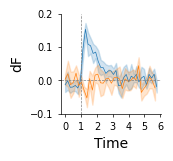

In [44]:

plt.rcParams['pdf.fonttype'] = 42
# 绘制图形
fig, ax = plt.subplots(figsize=(3.3/2.54, 3.3/2.54))
sns.lineplot(x="time", y="dF", data=selected_data, errorbar="se", ax=ax,linewidth=0.5)
sns.lineplot(x="time", y="dF", data=selected_data_2, errorbar="se", ax=ax,linewidth=0.5)
ax.set_ylim([-0.1, 0.2])
ax.set_xlabel('Time')
ax.set_ylabel('dF')
#ax.set_title('Line Plot')

# 设置 x 轴刻度
xticks = [0, 1, 2, 3, 4, 5,6]
ax.set_xticks(xticks)

# 设置刻度标签字体大小
ax.tick_params(axis='y', labelsize=7, width=0.5, length=2)
ax.tick_params(axis='x', labelsize=7, width=0.5, length=2)


ax.axvline(x=1, linestyle='--', color='gray',linewidth=0.5)
ax.axhline(y=0, linestyle='--', color='gray',linewidth=0.5)

# 去掉上方和右侧的框线
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)


# 保存图像
save_dir="C:\\Users\\user\\OneDrive\\PROJECT\\project\\RV\\RV_paper\\rabies\data\\fig2\\"
plt.savefig(save_dir+"20230817_N4_pre_post.pdf",format="pdf", transparent=True, dpi=300, bbox_inches="tight")

# 显示图像
plt.show()

In [42]:
# 计算 response latency
#如何计算响应潜伏期（Response Latency）
#确定刺激时间点：找到刺激发生的时间（通常可以在实验记录中找到）。
#检测钙信号上升的时间点：查看刺激后哪一帧开始出现明显的 ΔF/F 增加，通常可以使用基线（如刺激前几帧的平均值）+ 3×标准差作为阈值。
#计算潜伏期：用 第一帧钙信号上升的时间 - 刺激时间 作为 response latency。
import math
from scipy.stats import sem
def response_latency(dir,number,array_f0):
    raw=pd.read_csv(dir)
    name = dir.split(".csv")[0].split("aligned_")[1]
    
    column_number=len(raw.columns)
    particle_number=int((column_number-1)/ 2)
    inter=float(dir.split("_")[-1].split(".csv")[0])
    time_list=np.arange(len(raw)) * float(inter)
   
    data=pd.DataFrame({"time":time_list})

    value=raw.iloc[:,2*(number-1)+2]
    data.insert(1,"value",value)
    
    f0_cource=  [20,60,100,140,180]  # f0 time cource of pre-stimuli
    f0=[]
    for i in array_f0:   # 选择没有峰的区域作为F0
        t=f0_cource[i-1]
        t_x=np.array(value[int((t-15)/float(inter)) : int((t-5)/float(inter))])
        f0_ave=t_x.mean()
        f0_3std=t_x.std()*3
        t_res=int(math.ceil(t/float(inter)))
        response_delay = None
        if value[t_res] > f0_3std+f0_ave:
            response_delay=t_res*inter-t
        elif value[t_res+1] > f0_3std+f0_ave:
            response_delay=(t_res+1)*inter-t
        elif value[t_res+2] > f0_3std+f0_ave:
            response_delay=(t_res+2)*inter-t
        elif value[t_res+3] > f0_3std+f0_ave:
            response_delay=(t_res+3)*inter-t
        elif value[t_res+4] > f0_3std+f0_ave:
            response_delay=(t_res+4)*inter-t
        if response_delay is not None:
            f0.append(response_delay)
    print(inter)    
    mean_latency=np.mean(f0)
    sem_latency=sem(f0)
    return (mean_latency,sem_latency)

for i in [N2,N4,N6,N7,N9,N10,N11,N12,N13,N14,N15]:
    csv_dir=dir+i[0]+"\\"+i[1]+".csv"
    data=response_latency(csv_dir,i[2],i[5])
    print(data)



0.1852
(0.1932000000000036, 0.0029211869733625105)
0.1605
(0.15200000000000385, 0.0251022907321197)
0.1523
(0.19967499999999472, 0.022122777666168675)
0.1601
(0.22259999999999636, 0.01767766952966218)
0.1885
(0.28200000000000214, 0.13320491732665382)
0.1885
(0.17824999999999847, 0.03208354978281752)
0.1264
(0.332800000000006, 0.2128000000000014)
0.1605
(0.1875, nan)
0.123
(nan, nan)
0.1625
(nan, nan)
0.1803
(0.09827499999999478, 0.043896552161493574)


c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\13094\miniconda3\envs\RVproject\Lib\site-packages\nu

In [ ]:
# 收集boxplot 数据
a=[N2,N4,N6,N7,N9,N10,N11,N12,N13,N14,N15]
b=[[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[0,5],[15,20],[15,20],[15,20],[0,5]]
c=[[0,5],[0,5],[0,5],[0,5],[5,7.5],[0,5],[0,5],[12.5,20],[15,20],[0,2.5],[0,5]]

amp_array=[]
for i,j,k in  zip(a, b, c):

    csv_dir=dir+i[0]+"\\"+i[1]+".csv"
    csv_post_dir=dir+i[0]+"\\"+i[3]+".csv"
    
    data_pre=dqs_cal_noplot(csv_dir,i[2],i[5])
    data_post=dqs_cal_noplot(csv_post_dir,i[4],i[6])
    
    amp=[ave_peak(data_pre,j),ave_peak(data_post,k)]
    print(i,amp)
    amp_array.append(amp)
    

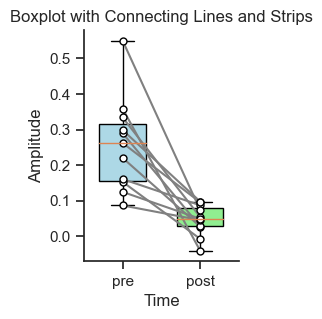

In [453]:
import matplotlib.pyplot as plt

# 定义数据

# 提取pre和post数据
pre_data = [x[0] for x in amp_array]
post_data = [x[1] for x in amp_array]

# 创建Figure和Axes对象
fig, ax = plt.subplots(figsize=(2, 3))

# 绘制Boxplot
bp_dict = ax.boxplot([pre_data, post_data], labels=['pre', 'post'], patch_artist=True,widths=0.6)

# 设置Boxplot颜色
colors = ['lightblue', 'lightgreen']
for patch, color in zip(bp_dict['boxes'], colors):
    patch.set_facecolor(color)

# 绘制连线
for i in range(len(amp_array)):
    ax.plot([1, 2], [pre_data[i], post_data[i]], color='gray')

# 绘制每个鱼点
ax = plt.gca()
for i, data in enumerate(amp_array):
    ax = plt.gca()
    ax.plot([1, 2], [data[0], data[1]], 'o', color='black', mfc='white',markersize=5)

# 设置标题和坐标轴标签
ax.set_title('Boxplot with Connecting Lines and Strips')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

# 取消上方和右侧的框线
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# 显示图形

save_dir="C:\\Users\\user\\OneDrive\\PROJECT\\project\\RV\\RV_paper\\rabies\data\\fig2\\"
plt.savefig(save_dir+"ele_calcium_amplitude_box.pdf")
plt.show()

In [454]:
from scipy.stats import ttest_rel

# 计算 t 值和 p 值
t, p = ttest_rel(pre_data, post_data)

# 打印结果
print('t 值：', t)
print('p 值：', p)

# 判断是否显著
if p < 0.05:
    print('差异显著')
else:
    print('差异不显著')

t 值： 5.17515496612175
p 值： 0.00041598624403571907
差异显著


144
432
720
1009
1297
1586


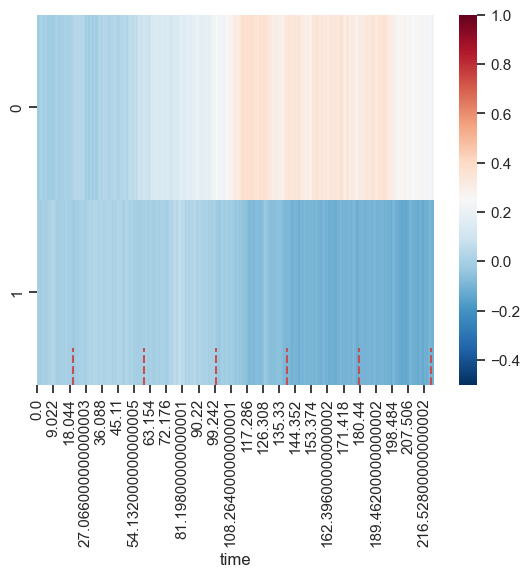

In [226]:
import seaborn as sns
import matplotlib.pyplot as plot
dir="\\\\10.10.48.40\\priortoreg_data\\311_data_CTL\\CTL_RV\\calcium\\20230602\\aligned_1_20230602_fish4_str1_03_0.1388.csv"
data=cal(dir)
real_time_max=data["time"].values[-1]
data=data.set_index("time")


g = sns.heatmap(data.T, cmap="RdBu_r", vmin=-0.5, vmax=1)
vertical_lines = [20, 60, 100, 140, 180, 220]  # 垂直线的位置
x_range = g.get_xlim()  # 获取heatmap的x轴范围


for x in vertical_lines:
    x_heatmap = (x - x_range[0]) / real_time_max # 转换为相对于x轴范围的比例

    x_plot = int(x_heatmap * x_range[1])  # 将比例乘以绘图区域的宽度
    print(x_plot)
    plt.axvline(x=x_plot,ymax=0.1, color='r', linestyle='--')  # 添加垂直线

plt.show()

## 降维

In [26]:
x=np.array(array)
# 均一化
y=standardization(x)
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, random_state=0).fit_transform(y) 
plt.scatter(tsne[:,0],tsne[:,1])


ModuleNotFoundError: No module named 'sklearn'

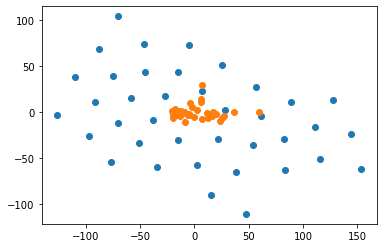

In [369]:
pca = PCA(n_components=2).fit_transform(y)
plt.scatter(tsne[:,0],tsne[:,1])
plt.scatter(pca[:,0],pca[:,1])


## diagram
直观呈现数据变化, 脑部轮廓以及每一个particle 均一化后的活动pattern  